# Notebook de modelisation

In [16]:
!uv pip install scikit-learn numpy hdbscan

Using Python 3.11.6 environment at: c:\Users\vuill\OneDrive\Documents\GitHub\OpenClassrooms\Projet 5 - Segmentez des clients d'un site e-commerce\.venv_p5
Audited 3 packages in 11ms


In [17]:
import pandas as pd
import numpy as np
from sklearn import cluster, metrics, mixture
from sklearn.datasets import make_blobs
import time
import hdbscan  # Pour HDBSCAN
from joblib import Parallel, delayed

# Import des dataframes RFM

In [24]:
rfm = pd.read_excel('RFM.xlsx')
rfm = rfm.drop(['customer_unique_id', 'Segment'], axis=1).dropna()
rfm.head()

,Unnamed: 0,R,F,M
0,0,160,1,141.90
1,1,163,1,27.19
2,2,585,1,86.22
3,3,369,1,43.62
4,4,336,1,196.89


In [25]:
rfmls  = pd.read_excel('RFMLS.xlsx')
rfmls = rfmls.drop(['customer_unique_id'], axis=1).dropna()
rfmls.head()

,Unnamed: 0,R,F,M,S,L
0,0,160,1,141.90,5,cajamar
1,1,163,1,27.19,4,osasco
2,2,585,1,86.22,3,sao jose
3,3,369,1,43.62,4,belem
4,4,336,1,196.89,5,sorocaba


# Benchmark des models

Les modèles de clustering dispo avec [sklearn](https://scikit-learn.org/stable/modules/clustering.html) et son tableau comparatif

![clustering compare image](https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png)

## Benchmark RFM

In [26]:
# On prend 10% des données pour gagné du temps d'execution
rfm_sample = rfm.sample(frac=0.1, random_state=42)
print(rfm_sample.shape)

(9610, 4)


In [27]:
def evaluate_algorithm(name, algorithm, data):
    start_time = time.time()

    # Fit et prédire les labels
    labels = algorithm.fit_predict(data)
    elapsed_time = time.time() - start_time

    # Calcul des scores
    silhouette_score = metrics.silhouette_score(data, labels) if len(set(labels)) > 1 else None
    davies_bouldin_score = metrics.davies_bouldin_score(data, labels) if len(set(labels)) > 1 else None
    calinski_harabasz_score = metrics.calinski_harabasz_score(data, labels) if len(set(labels)) > 1 else None

    return {
        "Algorithm": name,
        "Time (s)": elapsed_time,
        "Silhouette Score": silhouette_score,
        "Davies-Bouldin Score": davies_bouldin_score,
        "Calinski-Harabasz Score": calinski_harabasz_score
    }

In [28]:
# Liste des algorithmes à comparer
n_cluster_value = 3
min_sample_value = 5

model_list = {
    'kmeans': cluster.KMeans(n_clusters=n_cluster_value),
    'minibatchkmeans': cluster.MiniBatchKMeans(n_clusters=n_cluster_value),
    'hdbscan': hdbscan.HDBSCAN(min_cluster_size=min_sample_value),
    'gmm': mixture.GaussianMixture(n_components=n_cluster_value),
    'birch': cluster.Birch(n_clusters=n_cluster_value),
    'agglomerative': cluster.AgglomerativeClustering(n_clusters=n_cluster_value),
    'dbscan': cluster.DBSCAN(eps=0.5, min_samples=min_sample_value),
    'optics': cluster.OPTICS(min_samples=min_sample_value),
    'meanshift': cluster.MeanShift(),
}

In [29]:
results = []

# Exécution en parallèle avec joblib
results = Parallel(n_jobs=-1)(delayed(evaluate_algorithm)(name, algorithm, rfm_sample)for name, algorithm in model_list.items())

# Création d'un DataFrame pour afficher les résultats
results_df = pd.DataFrame(results)

In [30]:
results_df.columns

Index(['Algorithm', 'Time (s)', 'Silhouette Score', 'Davies-Bouldin Score',
       'Calinski-Harabasz Score'],
      dtype='object')

In [31]:
# Silhouette Score : Plus il est élevé, mieux c'est
# Davies-Bouldin Score : Plus il est faible, mieux c'est 
# Calinski-Harabasz Score : Plus il est élevé, mieux c'est

results_df.sort_values(by=['Silhouette Score', 'Davies-Bouldin Score', 'Calinski-Harabasz Score'], ascending=[False, True, False])

,Algorithm,Time (s),Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,kmeans,0.144518,0.593976,0.496601,38790.420061
1,minibatchkmeans,0.156687,0.593520,0.496789,38704.294564
4,birch,7.526125,0.593267,0.496833,38681.787083
5,agglomerative,11.947617,0.593267,0.496833,38681.787083
8,meanshift,133.723545,0.538532,0.503872,27050.627977
3,gmm,0.348104,-0.008147,79.002359,1.425147
2,hdbscan,0.527935,-0.292696,3.188928,49.324875
7,optics,22.388705,-0.446665,3.118335,12.360710
6,dbscan,0.112859,NaN,NaN,NaN


## Visualisation

### T-SNE

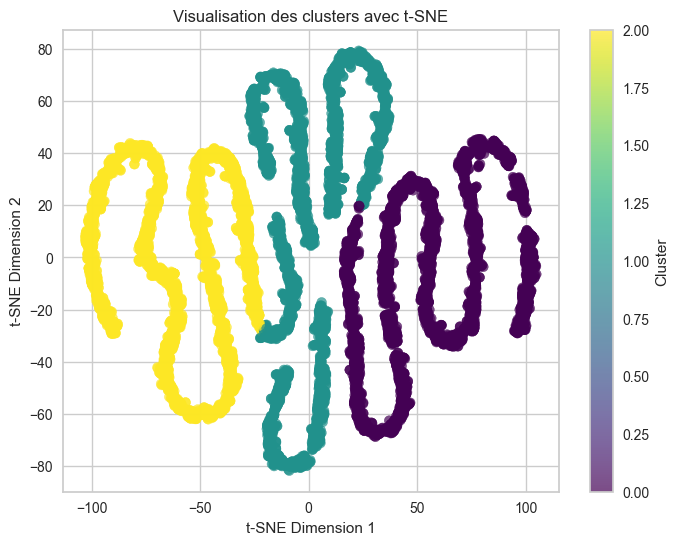

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Réduction en 2D avec t-SNE
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(rfm_sample)

# Prédictions du modèle KMeans
labels = model_list['birch'].fit_predict(rfm_sample)

# Affichage des clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Cluster")
plt.title("Visualisation des clusters avec t-SNE")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

### UMAP

c:\Users\223115316\Documents\GitHub\OC\Projet5\.venv_p5\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


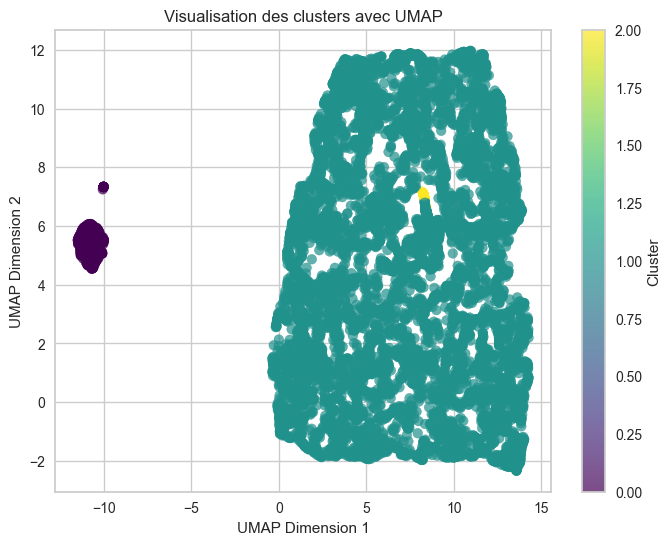

In [ ]:
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Standardisation des données (recommandé pour UMAP)
X_scaled = StandardScaler().fit_transform(rfm_sample)

# Réduction en 2D avec UMAP
umap_2d = umap.UMAP(n_components=2, random_state=42)
X_embedded = umap_2d.fit_transform(X_scaled)

# Prédictions du modèle KMeans (ou un autre)
labels = model_list['birch'].fit_predict(X_scaled)

# Affichage des clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Cluster")
plt.title("Visualisation des clusters avec UMAP")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


In [34]:
!uv pip install yellowbrick

Using Python 3.11.6 environment at: c:\Users\vuill\OneDrive\Documents\GitHub\OpenClassrooms\Projet 5 - Segmentez des clients d'un site e-commerce\.venv_p5
Resolved 16 packages in 532ms
Installed 1 package in 79ms
 + yellowbrick==1.5


### Yellow brick 

Evaluating kmeans...
Time (s): 0.0094
Silhouette Score: 0.5943
Davies-Bouldin Score: 0.4965
Calinski-Harabasz Score: 38798.5873


c:\Users\vuill\OneDrive\Documents\GitHub\OpenClassrooms\Projet 5 - Segmentez des clients d'un site e-commerce\.venv_p5\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
c:\Users\vuill\OneDrive\Documents\GitHub\OpenClassrooms\Projet 5 - Segmentez des clients d'un site e-commerce\.venv_p5\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


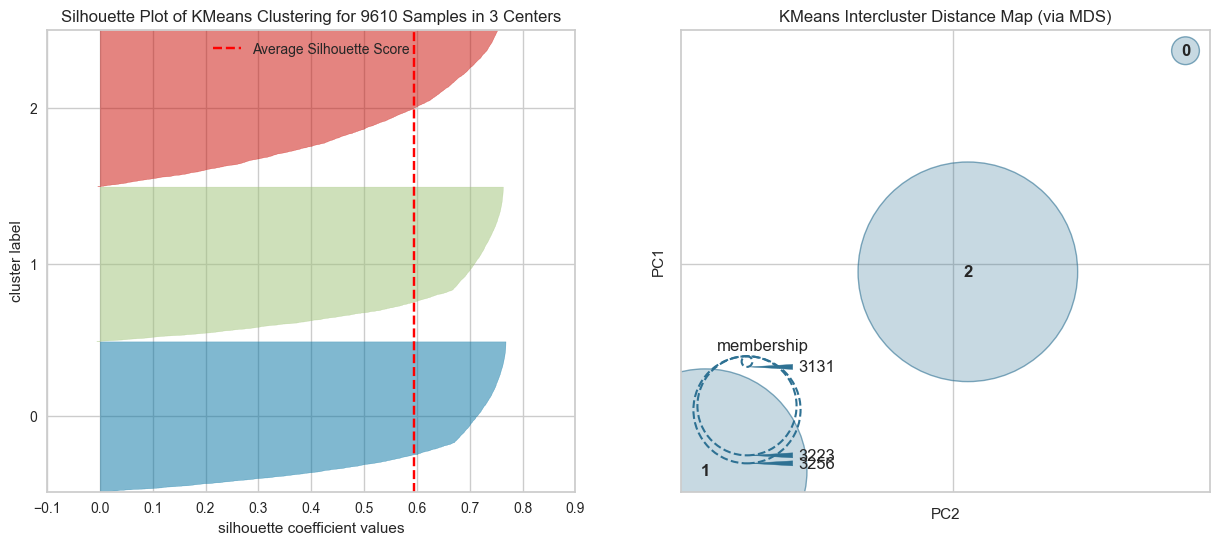

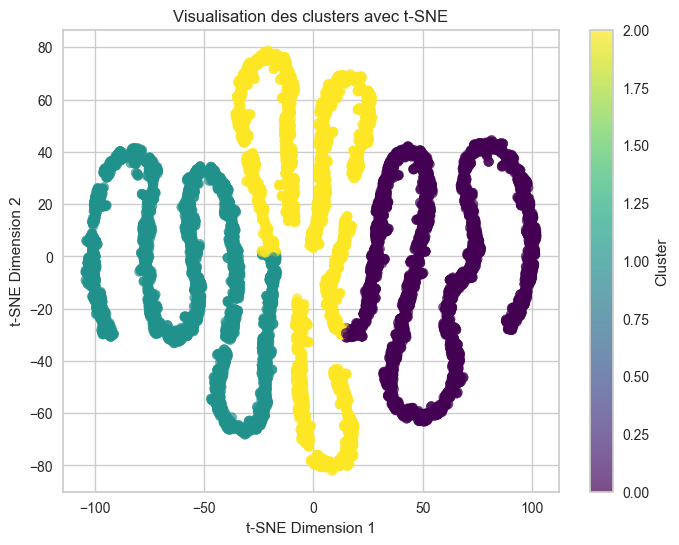

Evaluating minibatchkmeans...
Time (s): 0.0238
Silhouette Score: 0.5943
Davies-Bouldin Score: 0.4964
Calinski-Harabasz Score: 38723.8770


c:\Users\vuill\OneDrive\Documents\GitHub\OpenClassrooms\Projet 5 - Segmentez des clients d'un site e-commerce\.venv_p5\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MiniBatchKMeans was fitted with feature names
  warnings.warn(
c:\Users\vuill\OneDrive\Documents\GitHub\OpenClassrooms\Projet 5 - Segmentez des clients d'un site e-commerce\.venv_p5\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MiniBatchKMeans was fitted with feature names
  warnings.warn(


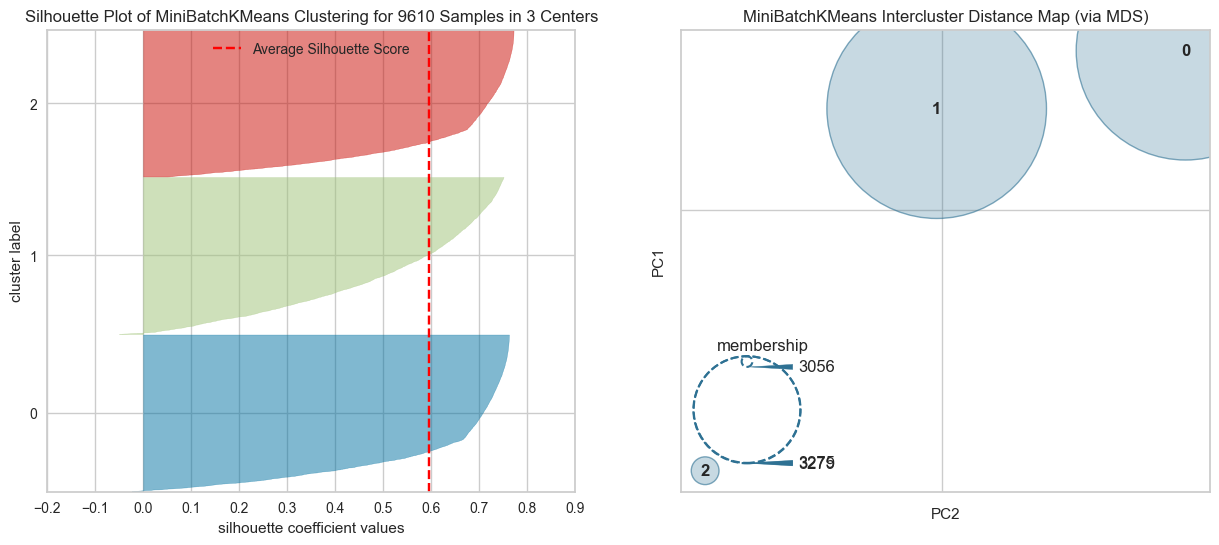

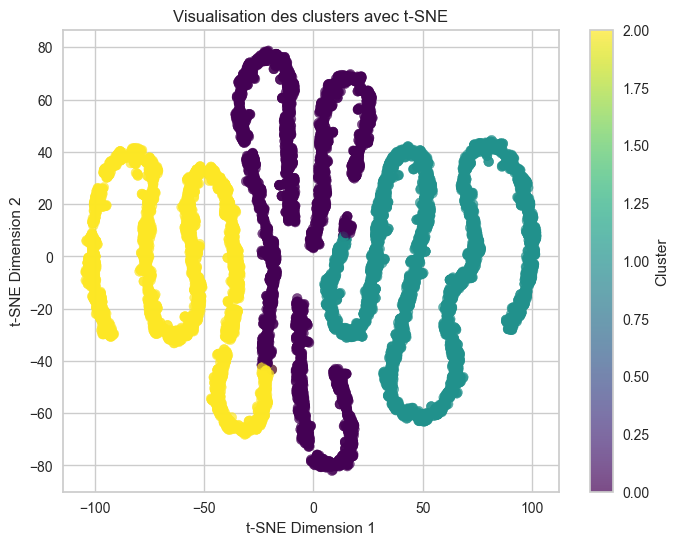

Evaluating hdbscan...


c:\Users\vuill\OneDrive\Documents\GitHub\OpenClassrooms\Projet 5 - Segmentez des clients d'un site e-commerce\.venv_p5\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vuill\OneDrive\Documents\GitHub\OpenClassrooms\Projet 5 - Segmentez des clients d'un site e-commerce\.venv_p5\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Time (s): 0.2746
Silhouette Score: 0.3702
Davies-Bouldin Score: 0.6665
Calinski-Harabasz Score: 119575.7886
Error visualizing silhouette for hdbscan: 'HDBSCAN' object has no attribute 'n_clusters'
Error visualizing intercluster distance for hdbscan: neither visualizer 'InterclusterDistance' nor wrapped estimator 'HDBSCAN' have attribute 'cluster_centers_'


c:\Users\vuill\OneDrive\Documents\GitHub\OpenClassrooms\Projet 5 - Segmentez des clients d'un site e-commerce\.venv_p5\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vuill\OneDrive\Documents\GitHub\OpenClassrooms\Projet 5 - Segmentez des clients d'un site e-commerce\.venv_p5\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


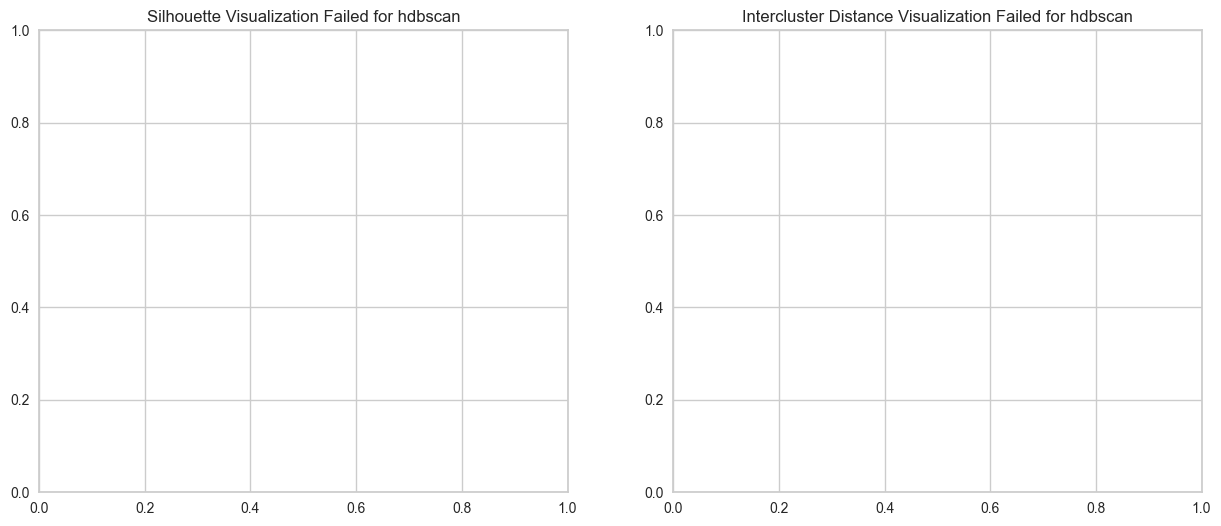

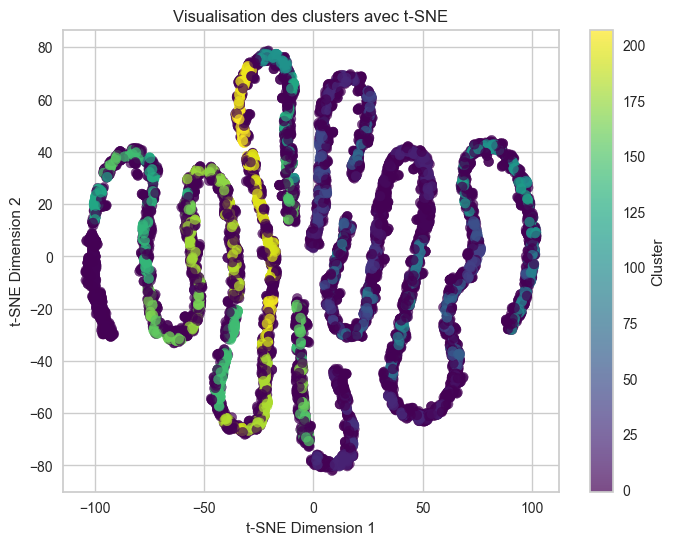

Evaluating gmm...
Time (s): 0.1290
Silhouette Score: -0.0032
Davies-Bouldin Score: 125.5455
Calinski-Harabasz Score: 0.4550
Error visualizing silhouette for gmm: The supplied model is not a clustering estimator; try a classifier or regression score visualizer instead!
Error visualizing intercluster distance for gmm: The supplied model is not a clustering estimator; try a classifier or regression score visualizer instead!


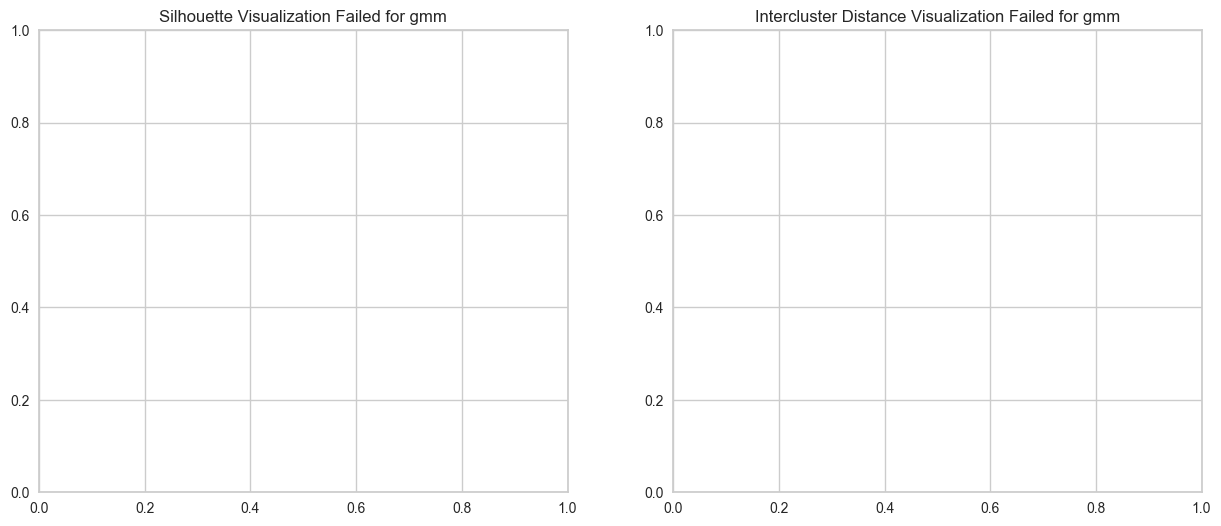

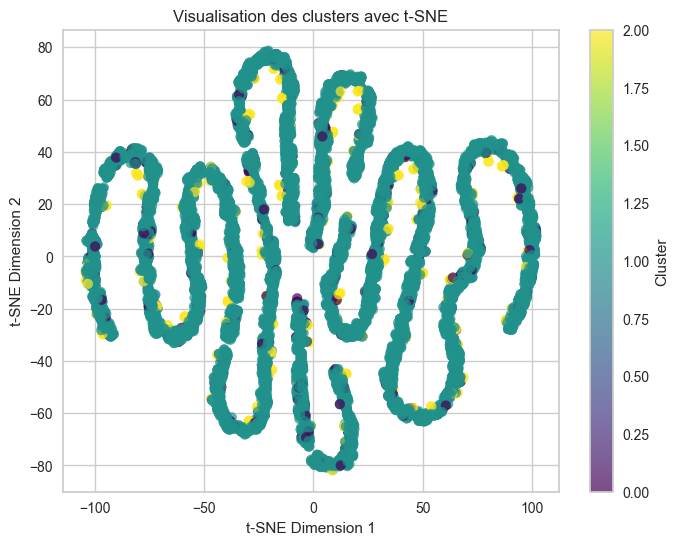

Evaluating birch...
Time (s): 2.9823
Silhouette Score: 0.5933
Davies-Bouldin Score: 0.4968
Calinski-Harabasz Score: 38681.7871


c:\Users\vuill\OneDrive\Documents\GitHub\OpenClassrooms\Projet 5 - Segmentez des clients d'un site e-commerce\.venv_p5\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  warnings.warn(
c:\Users\vuill\OneDrive\Documents\GitHub\OpenClassrooms\Projet 5 - Segmentez des clients d'un site e-commerce\.venv_p5\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  warnings.warn(


Error visualizing intercluster distance for birch: neither visualizer 'InterclusterDistance' nor wrapped estimator 'Birch' have attribute 'cluster_centers_'


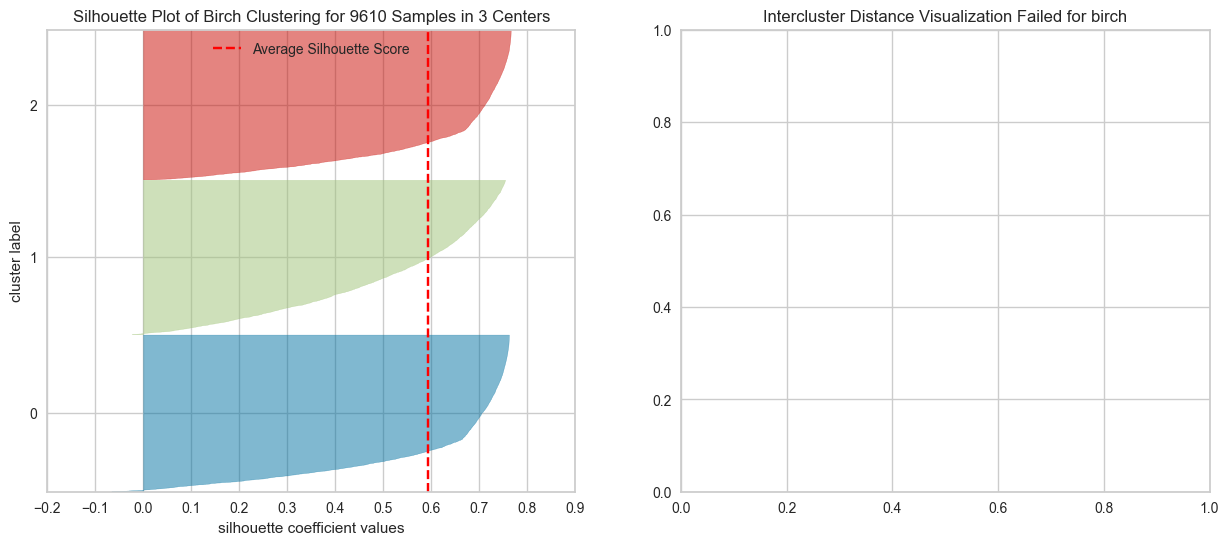

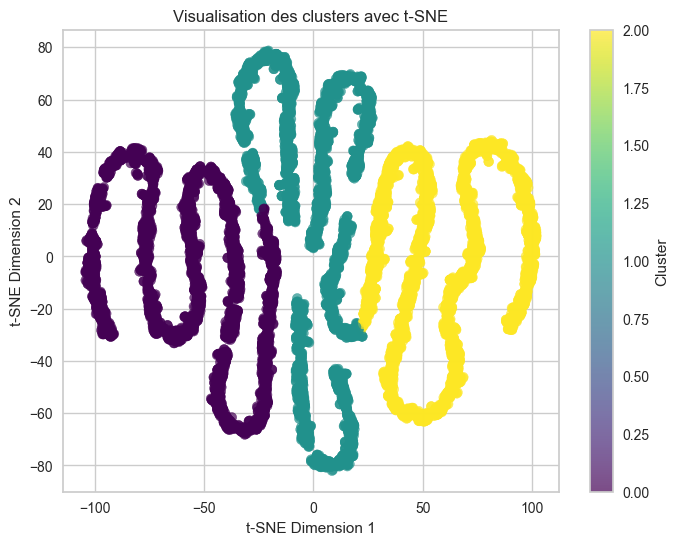

Evaluating agglomerative...
Time (s): 2.9802
Silhouette Score: 0.5933
Davies-Bouldin Score: 0.4968
Calinski-Harabasz Score: 38681.7871
Error visualizing silhouette for agglomerative: 'AgglomerativeClustering' object has no attribute 'predict'
Error visualizing intercluster distance for agglomerative: neither visualizer 'InterclusterDistance' nor wrapped estimator 'AgglomerativeClustering' have attribute 'cluster_centers_'


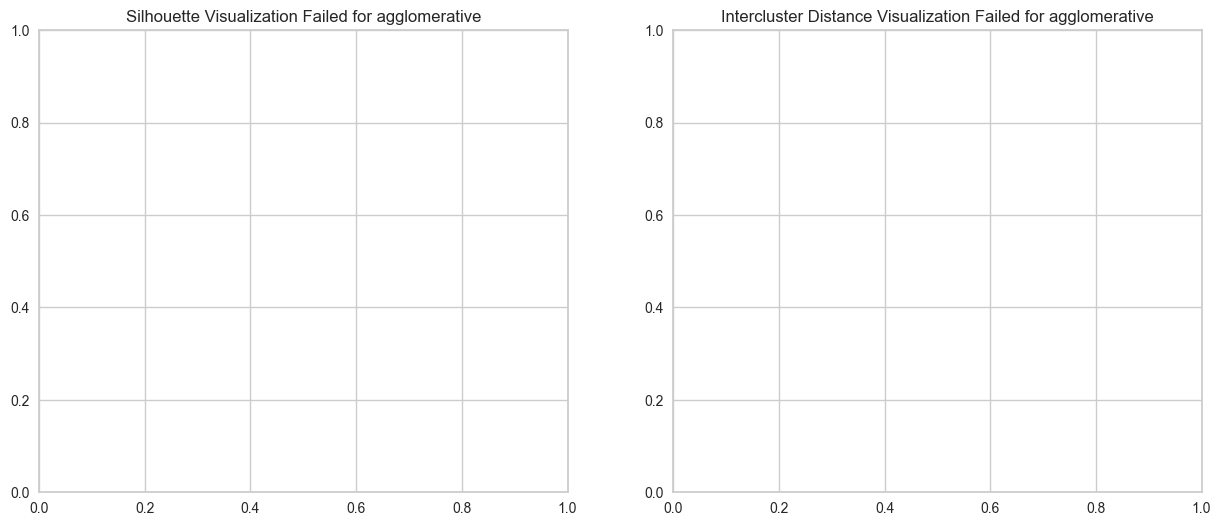

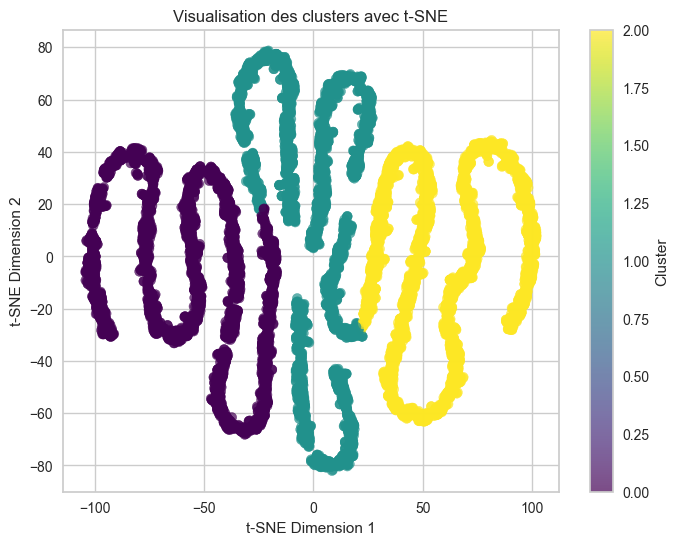

Evaluating dbscan...
Error calculating metrics for dbscan: Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required.
Error visualizing silhouette for dbscan: 'DBSCAN' object has no attribute 'n_clusters'
Error visualizing intercluster distance for dbscan: neither visualizer 'InterclusterDistance' nor wrapped estimator 'DBSCAN' have attribute 'cluster_centers_'


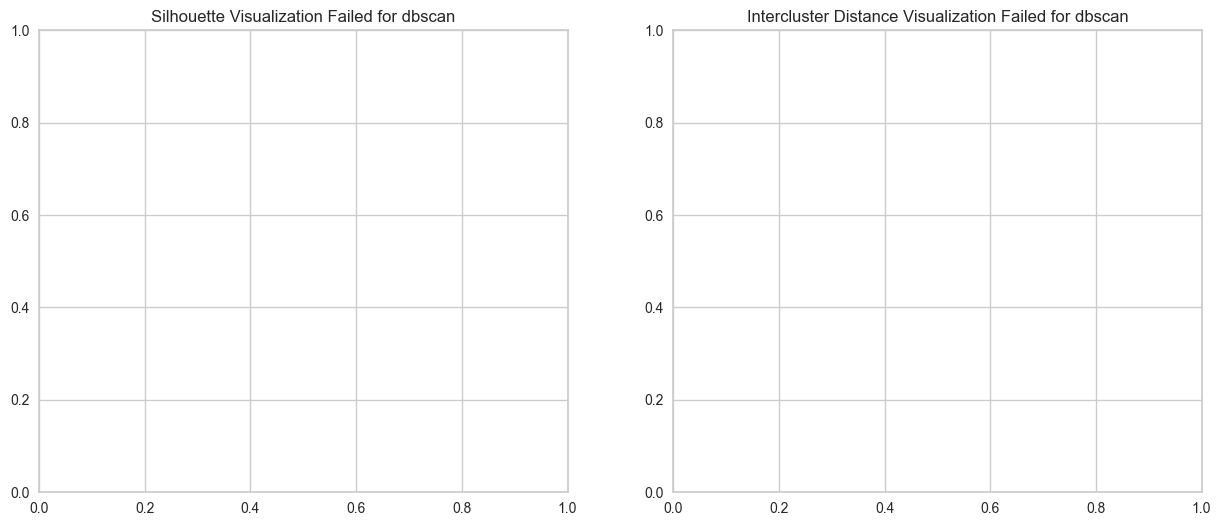

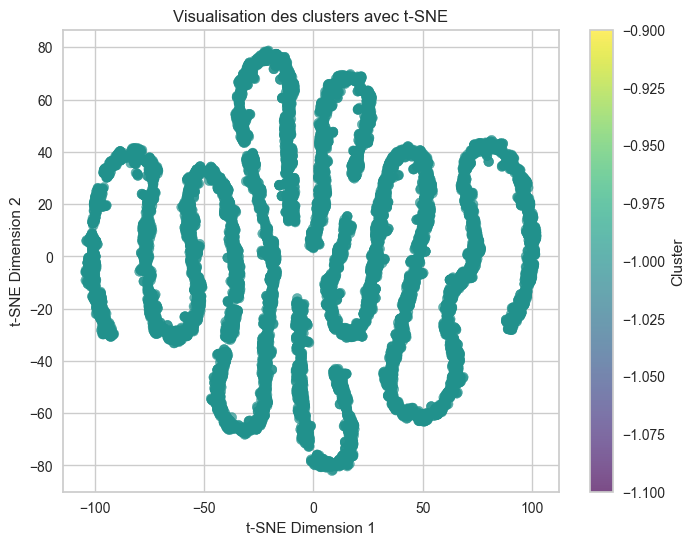

Evaluating optics...
Time (s): 13.1069
Silhouette Score: 0.5142
Davies-Bouldin Score: 0.6296
Calinski-Harabasz Score: 711947.1768
Error visualizing silhouette for optics: 'OPTICS' object has no attribute 'n_clusters'
Error visualizing intercluster distance for optics: neither visualizer 'InterclusterDistance' nor wrapped estimator 'OPTICS' have attribute 'cluster_centers_'


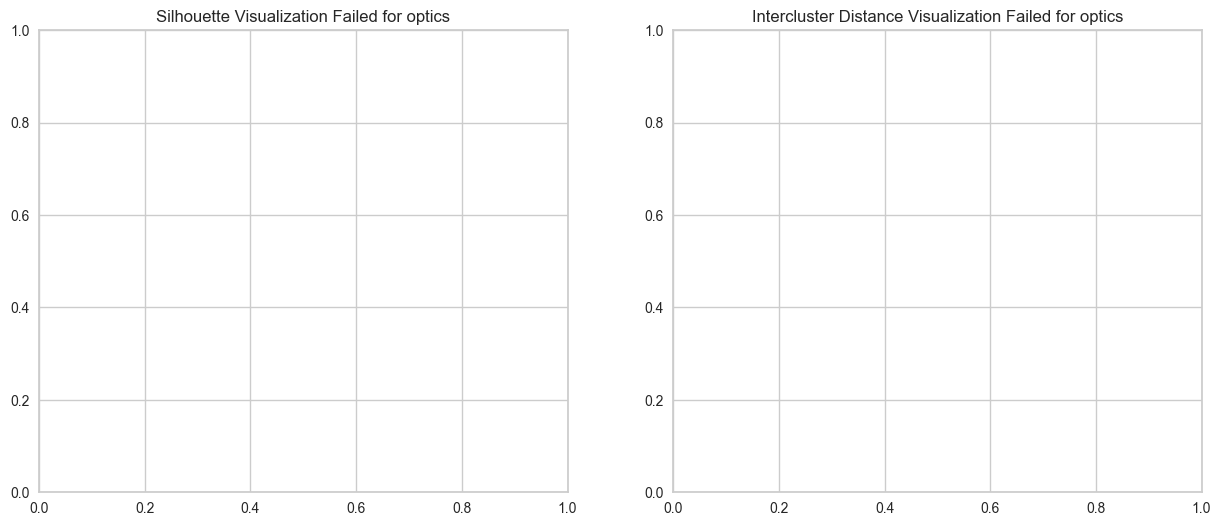

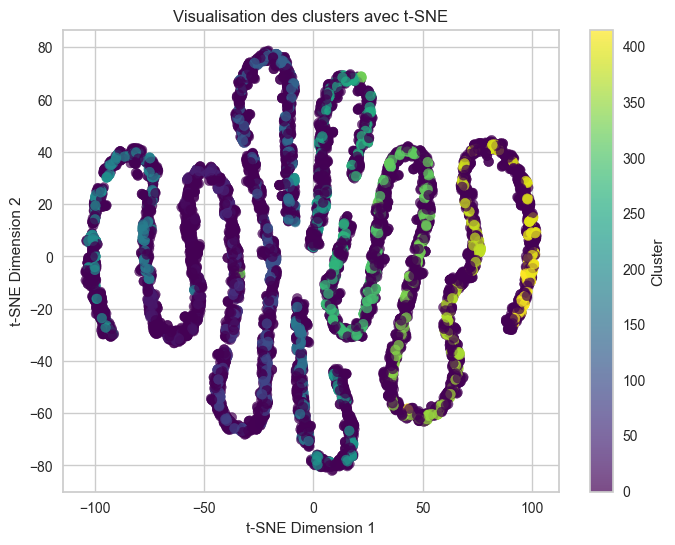

Evaluating meanshift...
Time (s): 127.5972
Silhouette Score: 0.5385
Davies-Bouldin Score: 0.5039
Calinski-Harabasz Score: 27050.6280
Error visualizing silhouette for meanshift: 'MeanShift' object has no attribute 'n_clusters'


c:\Users\vuill\OneDrive\Documents\GitHub\OpenClassrooms\Projet 5 - Segmentez des clients d'un site e-commerce\.venv_p5\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MeanShift was fitted with feature names
  warnings.warn(
c:\Users\vuill\OneDrive\Documents\GitHub\OpenClassrooms\Projet 5 - Segmentez des clients d'un site e-commerce\.venv_p5\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MeanShift was fitted with feature names
  warnings.warn(


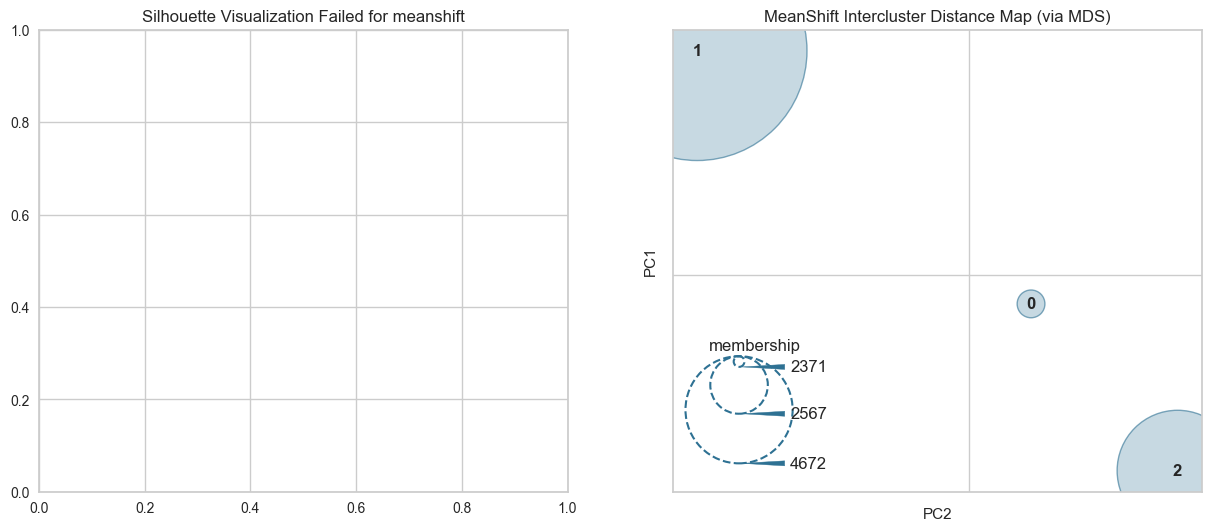

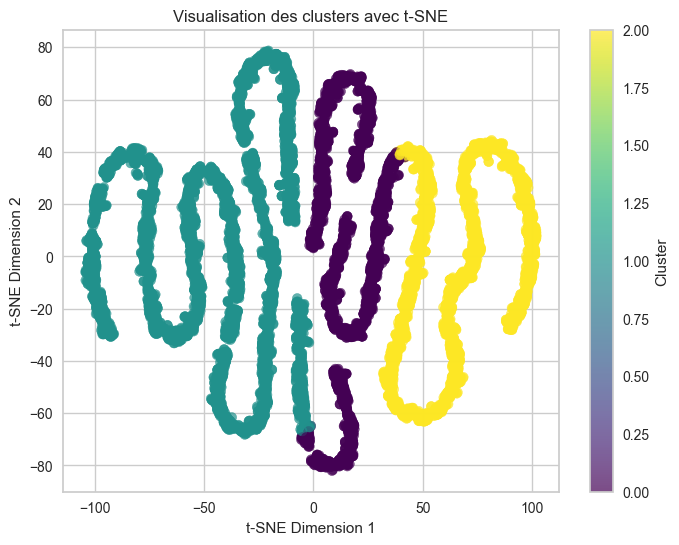

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance
from sklearn import cluster, mixture, decomposition
import hdbscan
import time

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def evaluate_and_visualize_clustering(model_name, model, X):
    """
    Évalue et visualise un modèle de clustering avec plusieurs métriques sans vraies étiquettes.

    :param model_name: Nom du modèle.
    :param model: Modèle de clustering déjà ajusté.
    :param X: Données d'entrée.
    """
    print(f"Evaluating {model_name}...")

    # Mesurer le temps d'exécution
    start_time = time.time()
    labels = model.fit_predict(X)
    end_time = time.time()
    time_taken = end_time - start_time

    # Filter out noise points for metric calculation if applicable
    if hasattr(model, 'labels_') and -1 in model.labels_:
        non_noise_indices = labels != -1
        X_filtered = X[non_noise_indices]
        labels_filtered = labels[non_noise_indices]
    else:
        X_filtered, labels_filtered = X, labels

    # Calculer les métriques
    try:
        silhouette_avg = silhouette_score(X_filtered, labels_filtered)
        davies_bouldin = davies_bouldin_score(X_filtered, labels_filtered)
        calinski_harabasz = calinski_harabasz_score(X_filtered, labels_filtered)

        print(f"Time (s): {time_taken:.4f}")
        print(f"Silhouette Score: {silhouette_avg:.4f}")
        print(f"Davies-Bouldin Score: {davies_bouldin:.4f}")
        print(f"Calinski-Harabasz Score: {calinski_harabasz:.4f}")
    except Exception as e:
        print(f"Error calculating metrics for {model_name}: {e}")

    # Visualisation avec Yellowbrick
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Visualisation de la silhouette
    try:
        visualizer = SilhouetteVisualizer(model, colors='yellowbrick', ax=ax[0])
        visualizer.fit(X)
        visualizer.finalize()
    except Exception as e:
        print(f"Error visualizing silhouette for {model_name}: {e}")
        ax[0].set_title(f"Silhouette Visualization Failed for {model_name}")

    # Visualisation des distances inter-clusters
    try:
        idm = InterclusterDistance(model, ax=ax[1])
        idm.fit(X)
        idm.finalize()
    except Exception as e:
        print(f"Error visualizing intercluster distance for {model_name}: {e}")
        ax[1].set_title(f"Intercluster Distance Visualization Failed for {model_name}")

    # Réduction en 2D avec t-SNE
    X_embedded = TSNE(n_components=2, random_state=42).fit_transform(rfm_sample)

    # Prédictions du modèle KMeans
    labels = model_list[model_name].fit_predict(rfm_sample)

    # Affichage des clusters
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label="Cluster")
    plt.title("Visualisation des clusters avec t-SNE")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

# Exemple d'utilisation
if __name__ == "__main__":


    for model_name, model in model_list.items():
        evaluate_and_visualize_clustering(model_name, model, rfm_sample)


## Training best models